#  Storm Benchmarks
Initial Statistics
------

This test was performed with the storm AdvertisingTopology reading from 5 kafka instances. 
The kafka instances were collectively fed json-serialized events at various throughputs:

 - 50000/s
 - 60000/s
 - 70000/s
 - 100000/s
 - 110000/s
 - 120000/s
 - 130000/s
 - 135000/s

### Graphs
Counts were calculated by the topology in 10-second windows, and updated counts were written to the redis database once per second.

Because we send updates to redis once per second, we expect most of the end-to-end latency measurments between kafka and redis to be less than 1000ms.

#### Histogram
The first graph is a normalized histogram of the amount of time in ms it took for a window to get its final update after the window officially ended. That is, once events stop being emitted for a window, this is how long it took for the final counts to be written. As expected, because of the 1s publishing period, the graph has a sharp dropoff at 1000ms - except for the 135000/s throughput in cyan. This is where the topology began to get behind on processing stuff from kafka, and indicates the upper bound of throughput that this topology will handle.

#### Percentiles
The rest of the graphs compare the percentiles of end-to-end latency (end-to-end being kafka producer to redis database) They don't measure on the granularity of tuples, but instead measure how long it takes for a window to converge on its final value after the window has ended. In other words, they measure the length of time between the final tuple for a given window being produced, and that tuple's data being written into redis. 

The first pair is end-to-end after the window close, and the second pair is end-to-end after the expected 1000ms latency.


In [3]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [4]:
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm

In [6]:
def get_filtered_updated(filename, window_size_ms):
    update_times = np.loadtxt(filename, dtype=int)
    filtered_times = [x - window_size_ms for x in update_times if x >= window_size_ms]
    return filtered_times

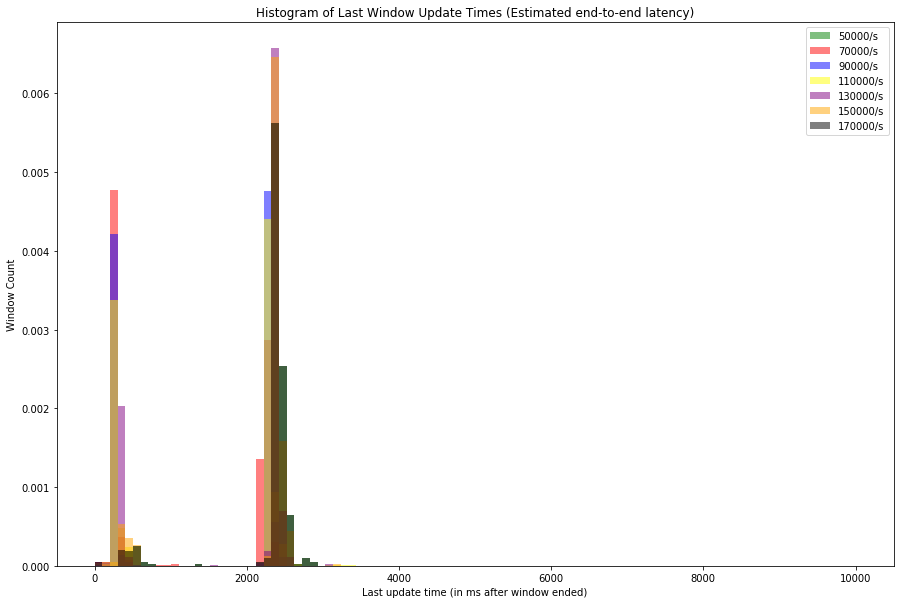

In [23]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("./first_run/SPARK/170000/updated.txt", "green", "50000"),
         ("./first_run/SPARK/70000/updated.txt", "red", "70000"),
         ("./first_run/SPARK/90000/updated.txt", "blue", "90000"),
         ("./first_run/SPARK/110000/updated.txt", "yellow", "110000"),
         ("./first_run/SPARK/130000/updated.txt", "purple", "130000"),
         ("./first_run/SPARK/150000/updated.txt", "orange", "150000"),
         ("./first_run/SPARK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency)')
plt.legend(loc="upper right")
plt.show()

## Percentiles

Percentiles for the last-update time. 90th percentile being within 1000ms or so indicates that the topology is keeping up with the throughput.

We can see that at ~135000 tuples/s input, the topology begins to fall behind, and end-to-end latency goes up.

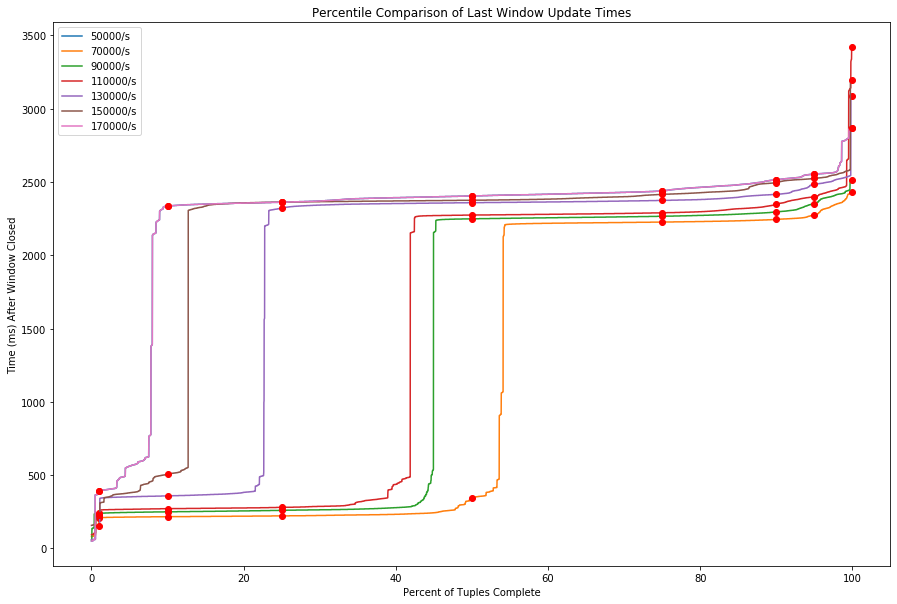

Percentiles:  [  1.  10.  25.  50.  75.  90.  95. 100.]


In [24]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 95.0, 100])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete')
plt.ylabel('Time (ms) After Window Closed')
plt.title('Percentile Comparison of Last Window Update Times')
plt.show()

print("Percentiles: ", p)

### *Late* Publishes
Here are the percentiles for the windows that were published *after* the expected 1000ms cutoff:

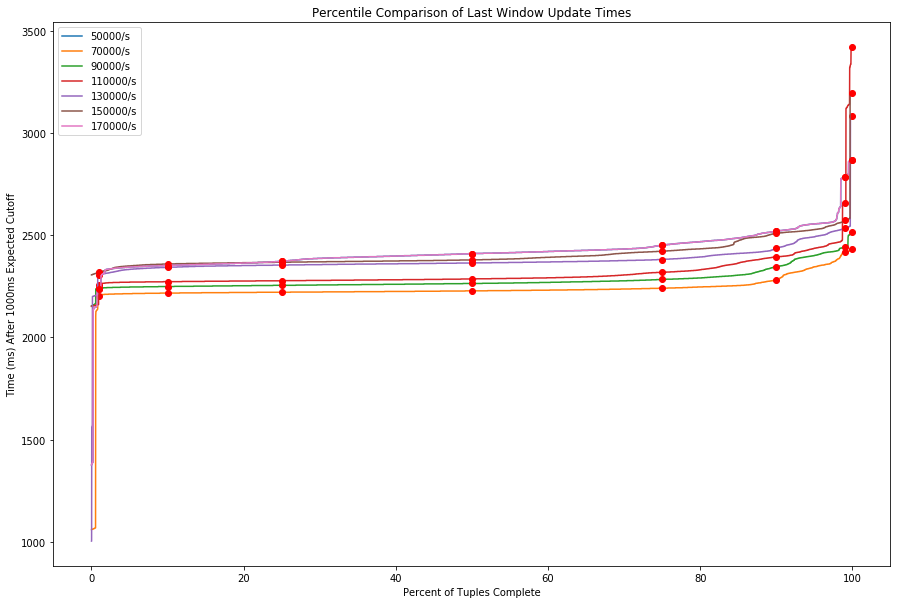

In [31]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0, 100])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.title('Percentile Comparison of Last Window Update Times')
plt.show()